# Vérification faciale


La vérification faciale consiste à confirmer l'identité d'une personne à partir d'une photo de référence. Par exemple, une entreprise peut stocker une photo de chaque employé dans une base de données. Lorsqu'un employé se présente à l'entrée avec son badge, le système compare sa photo à celle enregistrée pour vérifier son identité.


Cette tâche comporte plusieurs défis :
- On n'a pas toujours accès à de nombreuses photos de chaque employé pour l'entraînement.
- Il est préférable d'éviter de réentraîner le modèle chaque fois qu'un nouvel employé rejoint l'entreprise.


Pour résoudre ce problème, nous utiliserons la méthode décrite dans l'article [Learning a Similarity Metric Discriminatively, with Application to Face Verification](https://ieeexplore.ieee.org/stamp/stamp.jsp?tp=&arnumber=1467314). Cette méthode entraîne une mesure de similarité à partir des données.

Elle est particulièrement efficace pour les jeux de données contenant un grand nombre de catégories (chaque personne est une catégorie pour les visages) et/ou lorsque toutes les catégories ne sont pas disponibles lors de l'entraînement (nouvel employé).


Commençons par analyser quelques points théoriques de l'article pour comprendre le fonctionnement de la méthode, puis nous passerons à l'implémentation.


## Analyse théorique de l'article


### Intuition


L'idée principale de l'article est d'entraîner le modèle de manière contrastive sur des paires d'images. Deux scénarios sont possibles :
- Les deux images proviennent de la même catégorie.
- Les deux images proviennent de catégories différentes.

L'objectif est d'avoir un modèle $G_w$ qui mappe une image dans un espace latent où la distance euclidienne (ou cosinus) permet de différencier efficacement les éléments.

Plus formellement, on veut que :
$D_W(X_1,X_2) = \lVert G_W(X_1) - G_W(X_2)\rVert $ soit petite si $X_1$ et $X_2$ sont dans la même catégorie et grande s'ils sont dans des catégories différentes.


Le modèle est entraîné sur des paires d'images, et les poids de $G_W$ sont partagés.

L'architecture ressemble à ceci :

![siamese2](./images/siamese2.png)


### Fonction de perte contrastive


Comment définir notre fonction de perte pour cet objectif ? Prenons $Y$ comme le label de notre paire d'images. Si $Y$ vaut 0, les images proviennent de la même catégorie, sinon $Y$ vaut 1.

La fonction de perte contrastive s'exprime comme suit :
$L(Y,X_1,X_2)= (1-Y)\frac{1}{2}(D_W)^2 + (Y)\frac{1}{2}(max(0,m-D_W))²$

Cette fonction peut sembler complexe, mais elle est en réalité assez simple. Examinons les deux valeurs possibles de $Y$ :
- Si $Y = 0$, alors $L(Y,X_1,X_2)= \frac{1}{2}(D_W)^2$, ce qui correspond simplement à la distance $D_W$ définie précédemment.
- Si $Y = 1$, alors $L(Y,X_1,X_2)= \frac{1}{2}(max(0,m-D_W))²$. Cette partie nécessite une explication supplémentaire. On pourrait supposer que simplement utiliser $\frac{1}{D_W}$ permettrait de maximiser la distance (ce que l'on veut). En pratique, cela ne fonctionne pas car le modèle pourrait apprendre à séparer les éléments avec une marge très petite, ce qui pourrait poser des problèmes de généralisation. Le paramètre $m$ (marge) permet de spécifier une marge minimale de séparation entre les éléments différents. Cela rend le modèle plus robuste et stabilise l'entraînement.

**Note** : Pourquoi ne pas simplement minimiser $D_W(X_1,X_2)$ sur des paires d'images de la même catégorie uniquement ? Si on fait cela, le modèle peut "s'effondrer" et apprendre une solution triviale qui consiste à faire de $G_W$ une fonction constante, de sorte que la perte sera toujours égale à 0. En pratique, le modèle va toujours chercher la solution la plus simple, il faut donc veiller à bien définir ses fonctions de perte pour éviter que le modèle trouve un raccourci trivial.


### Architecture du modèle et entraînement


$G_W$ peut être n'importe quel réseau de neurones. L'article propose d'utiliser un réseau convolutif pour ses capacités sur les images et sa robustesse aux distorsions géométriques (fréquentes en vérification faciale).

Nous ne reproduirons pas strictement l'architecture de l'article, mais nous concevrons plutôt notre propre architecture et l'entraînerons sur un jeu de données plus conséquent que ceux de l'article.

Pour l'entraînement, l'article recommande d'utiliser 50% de paires positives et 50% de paires négatives.


## Implémentation


In [15]:
import torch 
import torch.nn as nn
import torch.nn.functional as F
import torchvision.datasets as datasets
import torchvision.transforms as T
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

Il est temps d'implémenter notre modèle !


### Jeu de données


Nous utilisons le jeu de données [LFW](https://vis-www.cs.umass.edu/lfw/) qui contient 13 233 images de 5 749 personnes, dont 1 680 ont au moins 2 images (nécessaire pour les exemples positifs). Nous utilisons [LFWPairs](https://pytorch.org/vision/main/generated/torchvision.datasets.LFWPairs.html) de torchvision, qui regroupe déjà les images par paires positives ou négatives en proportions égales.


In [100]:
transform = T.Compose([
    T.ToTensor(),
    T.Resize((128,128)), # On réduit la taille des images pour accélérer l'entraînement
])
train_data=datasets.LFWPairs(root='./../data',download=False,split= 'train',transform=transform)
test_data=datasets.LFWPairs(root='./../data',download=False,split= 'test',transform=transform)

Nombre de paires pour le training:  2200
Nombre de paires pour le test: 1000
Taille image torch.Size([3, 128, 128])


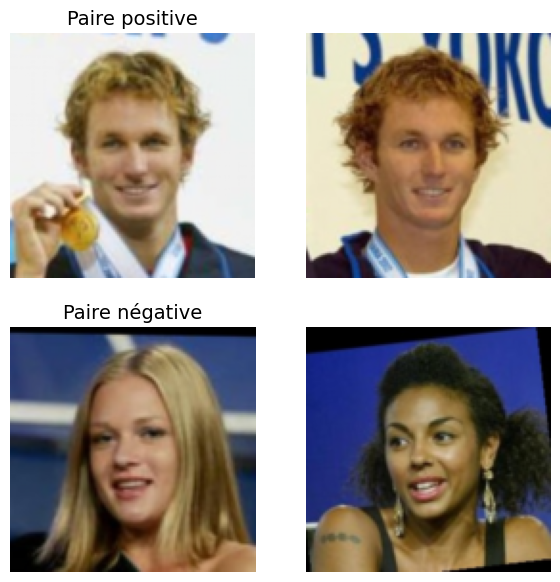

In [101]:
print('Nombre de paires pour le training: ',len(train_data))
print('Nombre de paires pour le test:',len(test_data))
print('Taille image',train_data[0][0].shape)

fig, axs = plt.subplots(2, 2, figsize=(7, 7))

axs[0, 0].imshow(train_data[0][0].permute(1, 2, 0))
axs[0, 0].axis('off')

axs[0, 1].imshow(train_data[0][1].permute(1, 2, 0))
axs[0, 1].axis('off')
for data in train_data:
  if data[2]==0:
    axs[1, 0].imshow(data[0].permute(1,2,0))
    axs[1, 0].axis('off')
    axs[1, 1].imshow(data[1].permute(1,2,0))
    axs[1, 1].axis('off')
    break
axs[0, 0].set_title("Paire positive", fontsize=14, ha='center')
axs[1, 0].set_title("Paire négative", fontsize=14, ha='center');


On remarque que dans le jeu de données, $Y=1$ correspond à une paire positive tandis que $Y=0$ correspond à une paire négative. C'est l'inverse des notations de l'article. Nous allons inverser cela pour plus de clarté.


In [102]:
# On ne peut pas modifier les données directement, on doit les transformer en listes
# Pour les données de training
train_data_list = [list(data) for data in train_data]
for data in train_data_list:
    data[2] = 1 - data[2]
train_data = [tuple(data) for data in train_data_list]

# Pour les données de test
test_data_list = [list(data) for data in test_data]
for data in test_data_list:
    data[2] = 1 - data[2]
test_data = [tuple(data) for data in test_data_list]

Nous allons maintenant pouvoir créer nos dataloaders :


In [103]:
train_loader = DataLoader(train_data, batch_size=16, shuffle=True)
test_loader = DataLoader(test_data, batch_size=16, shuffle=False)

### Fonction de perte contrastive


Il est temps de définir notre fonction de perte. Pour cela, nous allons simplement reprendre la formule que nous avons introduite précédemment. Pour $D_W$, nous prenons la distance euclidienne :
$D_W (X_1,X_2) = \lVert X_1 - X_2 \rVert_2 = \sqrt{\sum_{i=1}^{n} (X_{1,i} - X_{2,i})^2}$


In [104]:
class ContrastiveLoss(nn.Module):
    def __init__(self, margin=1.0):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, output1, output2, label):
        # Distance euclidienne entre les deux sorties du réseau
        euclidean_distance = F.pairwise_distance(output1, output2, keepdim=True)
        
        # Calcul du loss contrastif
        loss_contrastive = torch.mean(
            (1 - label) * torch.pow(euclidean_distance, 2) +
            (label) * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2)
        )
        
        return loss_contrastive

### Création de notre modèle


Pour cette tâche, nous allons construire un réseau convolutif classique et assez petit. Le but du modèle est de projeter les données dans un espace où la distance euclidienne est pertinente.


In [142]:
class SiameseNetwork(torch.nn.Module):

    def __init__(self):
        super(SiameseNetwork, self).__init__()

        # Extraction des features pertinentes
        self.conv_net = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=7, stride=2, padding=3),
            nn.ReLU(),
            nn.Conv2d(16, 32, kernel_size=5, stride=2, padding=2),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=5, stride=2, padding=2),
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
        )
        
        # Projection des features dans un espace de dimension réduite
        self.linear=nn.Sequential(
            nn.Linear(128 * 4 * 4, 256),
            nn.ReLU(),
            nn.Linear(256, 32), 
            )
    
    def forward(self, x1, x2):
        x1 = self.conv_net(x1)
        x2 = self.conv_net(x2)
        x1 = x1.view(x1.size(0), -1)
        x2 = x2.view(x2.size(0), -1)
        x1=self.linear(x1)
        x2=self.linear(x2)
        return x1,x2

### Entraînement du modèle


Définissons nos hyperparamètres d'entraînement :


In [134]:
epochs = 30
lr = 0.001
margin = 1.0
model = SiameseNetwork().to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=lr)
criterion=ContrastiveLoss(margin=margin)

In [135]:
for epoch in range(epochs):
  loss_train = 0
  for x1, x2, label in train_loader:
    x1, x2, label = x1.to(device), x2.to(device), label.to(device)
    optimizer.zero_grad()
    out1, out2 = model(x1, x2)
    loss = criterion(out1, out2, label)
    loss_train+=loss.item()
    loss.backward()
    optimizer.step()
  print(f"Epoch {epoch+1}/{epochs} Loss: {loss_train/len(train_loader)}")

Epoch 1/30 Loss: 0.4855058027998261
Epoch 2/30 Loss: 0.47506297098985617
Epoch 3/30 Loss: 0.44379603841166565
Epoch 4/30 Loss: 0.36472982092612033
Epoch 5/30 Loss: 0.31656959955243097
Epoch 6/30 Loss: 0.3091158025722573
Epoch 7/30 Loss: 0.2988005231903947
Epoch 8/30 Loss: 0.2873344306928524
Epoch 9/30 Loss: 0.28030256138763565
Epoch 10/30 Loss: 0.27428370077108993
Epoch 11/30 Loss: 0.27216234900381253
Epoch 12/30 Loss: 0.2714559338662935
Epoch 13/30 Loss: 0.2713507852260617
Epoch 14/30 Loss: 0.27069854628348694
Epoch 15/30 Loss: 0.26960040553324466
Epoch 16/30 Loss: 0.26909896256267163
Epoch 17/30 Loss: 0.2681442526155624
Epoch 18/30 Loss: 0.26780268636302673
Epoch 19/30 Loss: 0.2663887916267782
Epoch 20/30 Loss: 0.26515361407528754
Epoch 21/30 Loss: 0.26577359880658163
Epoch 22/30 Loss: 0.266544328543587
Epoch 23/30 Loss: 0.2644324919235879
Epoch 24/30 Loss: 0.26508791971465817
Epoch 25/30 Loss: 0.26529018699690915
Epoch 26/30 Loss: 0.26407808313767117
Epoch 27/30 Loss: 0.264637937796

### Évaluation du modèle


Maintenant que l'entraînement est terminé, il faut évaluer le modèle. Mais comment faire ? Ce n'est pas le type de modèle que nous avons l'habitude d'évaluer.

Nous avons notre jeu de données de test et nous pouvons calculer les distances entre chaque paire de ce jeu de données. Ainsi, nous pouvons obtenir un score de similarité pour chaque élément du jeu de données de test.

**La courbe ROC** : La courbe ROC (*Receiver Operating Characteristic*) est un graphique qui illustre les performances d'un modèle de classification binaire (positif ou négatif dans notre cas) à différents seuils de décision. La courbe ROC contient les éléments suivants :
- **Axe des X** : le taux de faux positifs (ou taux de fausse alarme). C'est le nombre d'éléments négatifs incorrectement classés comme positifs, divisé par le nombre total d'éléments négatifs.
- **Axe des Y** : le taux de vrais positifs (rappel ou sensibilité). C'est le nombre d'éléments positifs correctement classés comme positifs, divisé par le nombre total d'éléments positifs.

Chaque point de la courbe représente un seuil de décision différent pour la classification des éléments.

![roc](./images/roc.png)

Figure extraite de [blogpost](https://sefiks.com/2020/12/10/a-gentle-introduction-to-roc-curve-and-auc/).


Pour juger la qualité d'un modèle, on peut calculer l'aire sous la courbe ROC (AUROC). Dans le cas d'un classifieur aléatoire, on obtient un AUROC de 0,5, tandis que pour un classifieur parfait, l'AUROC est de 1.

Nous pouvons le calculer pour notre modèle :


In [139]:
from sklearn.metrics import roc_curve, auc

model.eval()
labels = []
distances = []
with torch.no_grad():
    for x1, x2, label in test_loader:
        x1, x2, label = x1.to(device), x2.to(device), label.to(device)
        out1, out2 = model(x1, x2)
        dist = torch.nn.functional.pairwise_distance(out1, out2)
        distances.extend(dist.cpu().numpy())
        labels.extend(label.cpu().numpy())
        
fpr, tpr, thresholds = roc_curve(labels, distances)
roc_auc = auc(fpr, tpr)
print(f"ROC AUC: {roc_auc}")


ROC AUC: 0.6163399999999999


Nous obtenons un AUROC d'environ 0,62, ce qui n'est vraiment pas terrible. Nous pouvons aussi tracer la courbe pour voir à quoi elle ressemble.


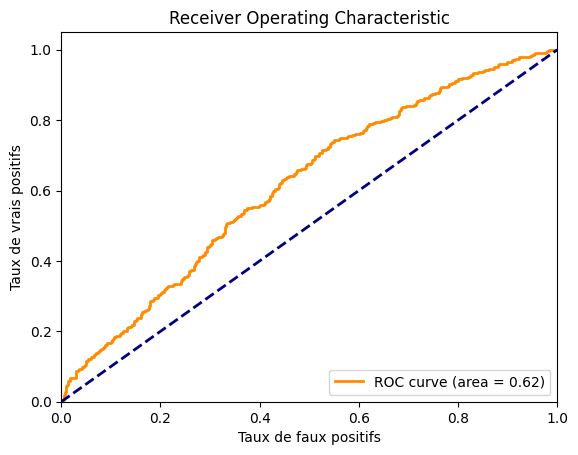

In [141]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Taux de faux positifs')
plt.ylabel('Taux de vrais positifs')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

On constate que le modèle n'est pas très performant. Le jeu de données est sans doute trop complexe par rapport à la taille de notre modèle. Vous pouvez essayer d'améliorer les performances du modèle en jouant sur l'architecture et les paramètres d'entraînement.


## Perte par triplet


### Reconnaissance faciale


Dans le domaine du traitement des visages, il existe deux catégories principales : la vérification faciale et la reconnaissance faciale.

Pour comprendre la nuance entre les deux, reprenons le cas de notre employé d'entreprise :
- **Vérification faciale** : Dans le cas de la vérification faciale, un employé veut entrer dans le bâtiment avec son badge. Il passe son badge dans la machine, et le modèle de vérification faciale vérifie qu'il s'agit bien de l'employé possédant ce badge.
- **Reconnaissance faciale** : Ici, il faut plutôt imaginer que l'employé se rend au bâtiment sans son badge et que le modèle est capable de le reconnaître parmi la base de données de tous les employés pour le laisser entrer dans le bâtiment.

Comme vous pouvez l'imaginer, la seconde tâche est plus complexe, que ce soit en termes de difficulté pure ou même en termes de contraintes de temps de traitement (on ne va pas faire attendre l'employé à la porte pendant une heure le temps de comparer sa photo aux centaines de photos de notre base de données).


### FaceNet


Pour la tâche de reconnaissance faciale, un article [FaceNet: A Unified Embedding for Face Recognition and Clustering](https://arxiv.org/pdf/1503.03832) a introduit un nouveau type de perte qui ressemble à la perte contrastive. Il s'agit de la perte par triplet que nous allons décrire brièvement.


L'objectif de cette perte est similaire à celui de la perte contrastive : elle vise à apprendre une représentation de sorte que les vecteurs de caractéristiques (ou *embeddings*) de points similaires soient rapprochés dans l'espace latent, tandis que ceux de points différents soient éloignés les uns des autres.

Contrairement à la perte contrastive qui se base sur des paires d'exemples, la perte par triplet se base sur des triplets d'exemples !

Chaque exemple a un rôle particulier :
- **Anchor (A)** : L'exemple de référence dont on cherche à apprendre une représentation.
- **Positive (P)** : Un exemple similaire à l'*anchor* (même personne, par exemple).
- **Negative (N)** : Un exemple différent de l'*anchor* (une personne différente).

La fonction de la perte est définie comme suit :
$L_{\text{triplet}} = \max\left( d(A, P) - d(A, N) + \alpha, 0 \right)$ où $d$ est la distance et $\alpha$ la marge (*margin*).

Cette perte minimise la distance entre $P$ et $A$ tout en maximisant celle entre $N$ et $A$.

![tripletloss](./images/tripletloss.png)

Figure extraite de l'article original.

Cela peut sembler redondant avec la perte contrastive, et c'est un peu le cas. Cependant, la perte par triplet a démontré de meilleurs résultats lorsqu'il s'agit de faire une distinction fine entre des classes assez similaires (typiquement le cas de la reconnaissance faciale). Aujourd'hui, son utilisation est préférée à celle de la perte contrastive pour les tâches de traitement des visages.
